In [1]:
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from lifetimes.plotting import *
from lifetimes.utils import *
os.chdir("../")
from src.models import BetaGeoModel
from src.data import (
    getDataset,
    ProcessData,
    RawFeatures
)

In [2]:
dt_format_ = '%d/%m/%Y %H:%M'
_dt_format = '%Y-%m-%d %H:%M'
df_transaction = getDataset()
df_transaction[RawFeatures.TRANSACTION_DATE] = df_transaction[RawFeatures.TRANSACTION_DATE].apply(
                                                    lambda x: dt.datetime.strptime(x, dt_format_).strftime(_dt_format) if x==x else x)

In [3]:
df_transaction.head()


,Customer ID,InvoiceDate,Price,Quantity
0,13085.0,2009-12-01 07:45,6.95,12.0
1,13085.0,2009-12-01 07:45,6.75,12.0
2,13085.0,2009-12-01 07:45,6.75,12.0
3,13085.0,2009-12-01 07:45,2.10,48.0
4,13085.0,2009-12-01 07:45,1.25,24.0


In [4]:
df_transaction[RawFeatures.TRANSACTION_DATE].sort_values()

0         2009-12-01 07:45
1         2009-12-01 07:45
2         2009-12-01 07:45
3         2009-12-01 07:45
4         2009-12-01 07:45
                ...       
981329    2011-12-09 12:49
981327    2011-12-09 12:49
981328    2011-12-09 12:49
981330    2011-12-09 12:49
633055                 NaN
Name: InvoiceDate, Length: 981331, dtype: object

In [5]:
# pd.to_datetime(
#    df_transaction[RawFeatures.TRANSACTION_DATE].dropna().apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M')),
# ).dt.date

In [6]:
data_inst = ProcessData(df_transaction, 'D', '2011-06-30')
data_summary = data_inst.model_data()
data_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12745.0,1.0,88.0,574.0,266.930000
12747.0,25.0,730.0,732.0,355.835600
12748.0,202.0,735.0,735.0,279.101436
12749.0,6.0,518.0,521.0,1010.743333


In [7]:
data_summary.describe().iloc[1:, :]

,frequency,recency,T,monetary_value
mean,6.490052,386.782461,526.574346,422.646958
std,10.721823,227.335755,201.691737,2771.151697
min,1.000000,1.000000,9.000000,3.900000
25%,2.000000,184.000000,412.500000,187.190000
50%,3.000000,389.000000,592.000000,300.305000
75%,7.000000,593.000000,690.000000,434.791667
max,202.000000,738.000000,738.000000,168469.600000


In [8]:
bgf = BetaGeoModel(data_summary, 7)
bgf.fit_()

In [9]:
# Compute the probability that a customer with history (frequency, recency, T) is currently alive.
bgf.conditional_probability_alive(
    frequency=25.0,
    recency=858.0,
    T=1062
)

array([0.58668023])

In [10]:
data_summary.apply(
    lambda x: bgf.conditional_probability_alive(
            frequency=x.frequency,
            recency=x.recency,
            T=data_summary["T"].max()
    )[0],
    axis=1
).sort_values().to_frame().reset_index().tail(1500)

,Customer ID,0
2320,14256.0,0.793250
2321,13509.0,0.793369
2322,14208.0,0.793847
2323,15532.0,0.794532
2324,16149.0,0.794606
...,...,...
3815,13089.0,0.998675
3816,14606.0,0.998851
3817,12748.0,0.998893
3818,17841.0,0.999107


In [11]:
data_summary[data_summary.index==16422.0]

,frequency,recency,T,monetary_value
Customer ID,,,,
16422.0,91.0,679.0,696.0,694.564505


# Model validation

In [12]:
# partition the dataset into a calibration and a holdout dataset
summary_cal_holdout = data_inst.model_cal_holdout_data()


In [13]:
# train BG/NBD model on the calibration data
bgf_cal = BetaGeoModel(
            data=summary_cal_holdout,
            T_prediction=7,
            penalizer_coef_=0.6
        )
bgf_cal.fit_validation()


# Plots

ConversionError: Failed to convert value(s) to axis units: '2010-01-14 10:35'

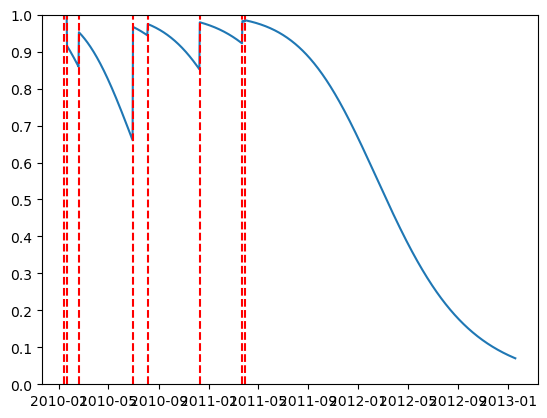

In [14]:
customer_id = 14256.0
days_since_birth = 1100
sp_trans = df_transaction.loc[df_transaction[RawFeatures.CUSTOMER_ID] == customer_id]
plot_history_alive(
    bgf,
    days_since_birth,
    sp_trans,
    RawFeatures.TRANSACTION_DATE
)
plt.show()

In [ ]:
help(plot_history_alive)

Help on function plot_history_alive in module lifetimes.plotting:

plot_history_alive(model, t, transactions, datetime_col, freq='D', start_date=None, ax=None, **kwargs)
    Draw a graph showing the probability of being alive for a customer in time.
    
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    t: int
        the number of time units since the birth we want to draw the p_alive
    transactions: pandas DataFrame
        DataFrame containing the transactions history of the customer_id
    datetime_col: str
        The column in the transactions that denotes the datetime the purchase was made
    freq: str, optional
        Default 'D' for days. Other examples= 'W' for weekly
    start_date: datetime, optional
        Limit xaxis to start date
    ax: matplotlib.AxesSubplot, optional
        Using user axes
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    
    Returns
    -------
    axes: matplotlib.AxesSubplot



In [ ]:
# plot_transaction_rate_heterogeneity(bgf);

# plot_dropout_rate_heterogeneity(bgf);

In [ ]:
# fig = plt.figure(figsize=(12, 6))
# plot_frequency_recency_matrix(bgf, T = 7)

# fig = plt.figure(figsize=(12, 6))
# plot_probability_alive_matrix(bgf)

# plt.show()

In [ ]:
# plot actual vs predicted frequency during the holdout period
# n represents the max frequency values to be plotted on the x-axis

plot_calibration_purchases_vs_holdout_purchases(
	bgf_cal,
	summary_cal_holdout,
	n=int(summary_cal_holdout['frequency_holdout'].max()),
	figsize = (8, 5)
)
plt.show();